# Detecting Kermit and Waldorf & Statler based on audio features

This notebook documents our approach to detect Kermit and Waldorf and Statler based on audio feature-engineering.  
We employ a Logistic Regression Classifier to predict the characters based on different audio-engineering features used for the different characters.

## Time sheet for this notebook

**Daniel Blasko:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  <tr>
    <td>27.11.2023</td>
    <td>Setup notebook, first experiments</td>
    <td>4</td>
  </tr>
  <tr>
    <td>27.11.2023</td>
    <td>Implement "utils/MuppetDataset.py" that generally loads and handles the annotated video data</td>
    <td>1</td>

  </tr>
  <tr>
    <td>28.11.2023</td>
    <td>Experiment & build feature extraction for both characters, align audio samples with frame annotations, format the dataset for the classifier</td>
    <td>4</td>
  </tr>
  <tr>
    <td>29.11.2023</td>
    <td>Add KNN classifier. Try other audio features due to poor performance for Waldorf & Statler, experiment with different splits</td>
    <td>4.5</td>
  </tr>
  <tr>
    <td>29.11.2023</td>
    <td>Add (visual) evaluation tools that generalize for all Sim1/2 tasks (cf. utils folder)</td>
    <td>1</td>
  </tr>
  <tr>
    <td>04.12.2023</td>
    <td>Analyze results, further attempts at improving performance, report on results/experiments</td>
    <td>6</td>
  </tr>
</tbody>
</table>


## Imports


In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import librosa.feature as lf
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)


import sys

sys.path.append("..")
from utils.MuppetDataset import MuppetDataset
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
)


## Loading the data

Set the booleans below to extract the audio/frames from the .avi files if it has not been done previously.


In [2]:
extract_audio = False
extract_frames = True


In [3]:
video_paths = [
    "../data/Muppets-02-01-01.avi",
    "../data/Muppets-02-04-04.avi",
    "../data/Muppets-03-04-03.avi",
]
annotation_paths = [
    "../data/GroundTruth_Muppets-02-01-01.csv",
    "../data/GroundTruth_Muppets-02-04-04.csv",
    "../data/GroundTruth_Muppets-03-04-03.csv",
]

dataset = MuppetDataset(video_paths, annotation_paths, extract_audio, extract_frames)


Example for handling the data for video 0:

```python
dataset.audio_paths[0]
dataset.audios[0]
dataset.annotations.loc[dataset.annotations.Video == 0]
```


## Audio feature extraction


### Aligning audio features with video frame rate

The annotations are at the video frame level, for audio too. Therefore, we need to align the audio features with the video frames.

We start by checking the framerate of the videos and remind of our audio sampling rate:


In [4]:
%%sh
ffprobe -v error -select_streams v:0 -show_entries stream=avg_frame_rate -of default=noprint_wrappers=1:nokey=1 ../data/Muppets-02-01-01.avi


25/1


In [5]:
FRAMES_PER_SECOND = 25


In [6]:
AUDIO_SAMPLING_RATE = dataset.audios[0]["sr"]
AUDIO_SAMPLING_RATE


44100

There are 25 frames per second, and the 16k audio samples per second.  
We therefore have $\frac{44100}{25} = 1764$ audio samples per frame and divide our audio features in windows of 1764 samples.


### Features for Kermit

We make our decisions based on the observation that Kermit displays a distinct audio pattern where his interventions start with screaming, and transition to mumbling as he speaks, which should correspond to a high foundational frequency.  
We therefore decide to extract the fundational frequency of the audio (pitch), as well as loudness.

**We normalize all extracted features.**


In [7]:
for idx, audio in enumerate(dataset.audios):
    # Pad audio with silence to extract features from the last 8 frames
    video_length_in_frames = (
        dataset.annotations.loc[dataset.annotations.Video == idx].Frame_number.max() + 1
    ) - 1

    video_duration_seconds = (video_length_in_frames) / FRAMES_PER_SECOND
    required_audio_length = int(video_duration_seconds * AUDIO_SAMPLING_RATE)

    audio["audio"] = np.pad(
        audio["audio"],
        (0, required_audio_length - audio["audio"].shape[0]),
        "constant",
    )
    # Loudness (through RMS energy)
    audio["loudness_rms"] = librosa.util.normalize(
        librosa.feature.rms(
            y=audio["audio"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            frame_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )[0]
    )
    # Zero crossing rate
    audio["zcr"] = librosa.util.normalize(
        librosa.feature.zero_crossing_rate(
            y=audio["audio"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            frame_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )[0]
    )


This approach with the `hop_length` of 1764 samples leads to feature vectors of the length of the number of frames, which is what we desired.


### Features for Waldorf & Statler

As for Waldorf & Statler, we observe they have low, cranky voices with a very specific overtone structure.  
We therefore decide to extract spectral and timber features.

However, as this will be discussed in the evaluation part, many features we tried were not useful and lead to very bad classifiers. After different experiments, we have kept the MFCCs, that do describe the timbre of the sound by representing the short-term power spectrum of the signal. Those led to the best performance in our experiments.


In [8]:
for audio in dataset.audios:
    # Spectral contrast measures the difference in amplitude between peaks and valleys in the spectrum, which can capture aspects of timbre
    audio["spectral_contrast"] = librosa.util.normalize(
        librosa.feature.spectral_contrast(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
            n_bands=5,
        )
    )  # spectral contrast values across n_bands different frequency bands for each frame, +1 that is "overall"
    # Spectral roll-off provides insights into the shape of the spectral energy distribution, affecting the timbre
    audio["spectral_rolloff"] = librosa.util.normalize(
        librosa.feature.spectral_rolloff(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )[0]
    )
    # Chroma features represent the energy distribution across different pitch classes and can provide a view of the harmonic content that contributes to timbre.
    audio["chroma"] = librosa.util.normalize(
        librosa.feature.chroma_stft(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )
    )
    # MFCCs are one of the most popular features for capturing the timbre of a sound. They effectively represent the short-term power spectrum of a sound.
    audio["mfcc"] = librosa.util.normalize(
        librosa.feature.mfcc(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
            n_mfcc=19,
        )
    )
    # Spectral centroid indicates the “center of mass” of the spectrum and can be used to describe the brightness of a sound, a key aspect of timbre.
    audio["spectral_centroid"] = librosa.util.normalize(
        librosa.feature.spectral_centroid(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )
    )[0]
    # Pitch
    pitches, magnitudes = librosa.piptrack(
        y=audio["audio"],
        sr=audio["sr"],
        hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
        win_length=int(audio["sr"] / FRAMES_PER_SECOND),
    )
    audio["pitch_mean"] = librosa.util.normalize(pitches.mean(axis=0))
    audio["magnitude_mean"] = librosa.util.normalize(magnitudes.mean(axis=0))
    audio["pitch_sd"] = librosa.util.normalize(pitches.std(axis=0))
    audio["magnitude_sd"] = librosa.util.normalize(magnitudes.std(axis=0))
    audio["pitch_min"] = librosa.util.normalize(pitches.min(axis=0))
    audio["magnitude_min"] = librosa.util.normalize(magnitudes.min(axis=0))
    audio["pitch_max"] = librosa.util.normalize(pitches.min(axis=0))
    audio["magnitude_max"] = librosa.util.normalize(magnitudes.min(axis=0))


In [9]:
dataset.audios[0]["magnitude_sd"].shape


(38681,)

In [10]:
for i in range(3):
    assert (
        dataset.audios[i]["spectral_rolloff"].shape[0]
        == dataset.annotations.loc[dataset.annotations.Video == i].Frame_number.max()
        + 1
    )


### Merge into the dataframe that will be used for model training & prepare the model dataset

We merge all information into a dataframe with columns `[video_idx, frame_idx, loudness_rms, zcr, spectral_contrast_columns*5, spectral_rolloff, kermit_present, waldorf_statler_present]`.


In [11]:
audio_features = pd.DataFrame()
for video_idx, audio in enumerate(dataset.audios):
    video_length_in_frames = (
        dataset.annotations.loc[
            dataset.annotations.Video == video_idx
        ].Frame_number.max()
        + 1
    )
    audio_features = pd.concat(
        [
            audio_features,
            pd.DataFrame(
                {
                    "video_idx": np.repeat(video_idx, video_length_in_frames),
                    "frame_idx": np.arange(0, video_length_in_frames),
                    "loudness_rms": audio["loudness_rms"],
                    "zcr": audio["zcr"],
                    # "spectral_contrast_1": audio["spectral_contrast"][0],
                    # "spectral_contrast_2": audio["spectral_contrast"][1],
                    # "spectral_contrast_3": audio["spectral_contrast"][2],
                    # "spectral_contrast_4": audio["spectral_contrast"][3],
                    # "spectral_contrast_5": audio["spectral_contrast"][4],
                    # "spectral_contrast_6": audio["spectral_contrast"][5],
                    # "chroma1": audio["chroma"][0],
                    # "chroma2": audio["chroma"][1],
                    # "chroma3": audio["chroma"][2],
                    # "chroma4": audio["chroma"][3],
                    # "chroma5": audio["chroma"][4],
                    # "chroma6": audio["chroma"][5],
                    "mfcc1": audio["mfcc"][0],
                    "mfcc2": audio["mfcc"][1],
                    "mfcc3": audio["mfcc"][2],
                    "mfcc4": audio["mfcc"][3],
                    "mfcc5": audio["mfcc"][4],
                    "mfcc6": audio["mfcc"][5],
                    "mfcc7": audio["mfcc"][6],
                    "mfcc8": audio["mfcc"][7],
                    "mfcc9": audio["mfcc"][8],
                    "mfcc10": audio["mfcc"][9],
                    "mfcc11": audio["mfcc"][10],
                    "mfcc12": audio["mfcc"][11],
                    "mfcc13": audio["mfcc"][12],
                    "mfcc14": audio["mfcc"][13],
                    "mfcc15": audio["mfcc"][14],
                    "mfcc16": audio["mfcc"][15],
                    "mfcc17": audio["mfcc"][16],
                    "mfcc18": audio["mfcc"][17],
                    "mfcc19": audio["mfcc"][18],
                    # "spectral_rolloff": audio["spectral_rolloff"],
                    # "spectral_centroid": audio["spectral_centroid"],
                    # "pitch_mean": audio[
                    #     "pitch_mean"
                    # ],  # THESE W/O MFCC DO PRETTY WELL BUT BAD FOR W&S
                    # "magnitude_mean": audio["magnitude_mean"],
                    # "pitch_sd": audio["pitch_sd"],
                    # "magnitude_sd": audio["magnitude_sd"],
                    # "pitch_min": audio["pitch_min"],
                    # "magnitude_min": audio["magnitude_min"],
                    # "pitch_max": audio["pitch_max"],
                    # "magnitude_max": audio["magnitude_max"],
                }
            ),
        ],
        ignore_index=True,
    )
# Add annotations
audio_features = audio_features.merge(
    dataset.annotations[["Video", "Frame_number", "Kermit", "Audio_StatlerWaldorf"]],
    how="left",
    left_on=["video_idx", "frame_idx"],
    right_on=["Video", "Frame_number"],
)
audio_features = audio_features.drop(columns=["Frame_number", "Video"])


Sanity check:


In [12]:
assert dataset.annotations.shape[0] == audio_features.shape[0]
assert dataset.annotations["Kermit"].sum() == audio_features["Kermit"].sum()
np.testing.assert_array_equal(
    dataset.annotations["Kermit"].values, audio_features["Kermit"].values
)
np.testing.assert_array_equal(
    dataset.annotations["Audio_StatlerWaldorf"].values,
    audio_features["Audio_StatlerWaldorf"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Video"].values,
    audio_features["video_idx"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Frame_number"].values,
    audio_features["frame_idx"].values,
)


In [13]:
audio_features.sample(10)


,video_idx,frame_idx,loudness_rms,zcr,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,Kermit,Audio_StatlerWaldorf
68655,1,29974,0.022410,0.114954,-1.0,0.239964,0.005219,-0.026549,0.025813,-0.000605,...,-0.002917,-0.021524,-0.001647,0.043841,0.037454,-0.009871,-0.005118,0.025714,1,0
103225,2,25838,0.200911,0.091391,-1.0,0.563640,-0.038533,0.003143,-0.013684,-0.004153,...,-0.100418,-0.077359,-0.039571,0.002155,0.001058,0.010274,0.021641,-0.020707,1,0
6021,0,6021,0.333609,0.048017,-1.0,0.632266,-0.138318,0.088446,0.014640,0.030208,...,0.028746,-0.008527,-0.010443,0.010903,0.039915,0.001415,-0.005236,-0.012538,0,0
11451,0,11451,0.749236,0.160752,-1.0,0.556659,-0.354278,0.049254,0.098841,-0.009267,...,0.014726,-0.050202,-0.035198,0.020511,-0.003880,-0.024263,-0.031555,-0.023641,1,0
46765,1,8084,0.018230,0.052899,-1.0,0.242553,0.079291,-0.008945,-0.017741,-0.001699,...,0.021082,0.012078,0.005696,-0.002388,-0.009340,-0.010502,-0.003540,0.006724,0,0
17744,0,17744,0.200579,0.082463,-1.0,0.411168,-0.133770,0.050692,-0.003664,-0.000984,...,-0.040254,-0.028056,-0.033471,-0.048940,-0.000611,0.020773,-0.053543,-0.060576,0,0
63886,1,25205,0.309978,0.096643,-1.0,0.630015,-0.192355,0.018534,-0.149290,0.069877,...,-0.006328,0.044414,-0.030973,-0.031493,0.056567,0.017343,0.034097,0.002166,0,0
99142,2,21755,0.007538,0.150993,-1.0,0.149548,0.048466,0.013336,0.012731,0.011081,...,0.013202,-0.002465,-0.007063,-0.003687,0.000905,0.008903,0.009763,0.006739,0,0
61550,1,22869,0.173107,0.229908,-1.0,0.433564,-0.265880,0.181323,-0.106847,0.057717,...,-0.007985,-0.010161,-0.034403,-0.013627,-0.024454,0.039390,0.017318,-0.003404,1,0
85804,2,8417,0.399184,0.135099,-1.0,0.801697,-0.219839,0.089591,-0.074114,0.021767,...,-0.009283,0.002878,-0.004864,-0.049070,-0.002473,0.028201,-0.017175,-0.007384,1,0


In [14]:
audio_features.describe()


,video_idx,frame_idx,loudness_rms,zcr,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,Kermit,Audio_StatlerWaldorf
count,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,...,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000
mean,0.998421,19313.777952,0.277597,0.142501,-0.999845,0.515892,-0.198498,0.082622,-0.055819,0.020853,...,-0.011054,-0.010243,-0.012859,-0.009178,-0.006820,-0.006224,-0.004611,-0.009636,0.286569,0.023446
std,0.816088,11151.279978,0.175298,0.097122,0.003453,0.196680,0.157292,0.093794,0.093546,0.064005,...,0.033086,0.031954,0.030795,0.029480,0.029250,0.028007,0.027807,0.027119,0.452160,0.151315
min,0.000000,0.000000,0.000000,0.000000,-1.000000,-0.171666,-0.837417,-0.261846,-0.584988,-0.244149,...,-0.211301,-0.199215,-0.220244,-0.164600,-0.194415,-0.178430,-0.232009,-0.176632,0.000000,0.000000
25%,0.000000,9657.000000,0.132622,0.085595,-1.000000,0.382151,-0.301866,0.018566,-0.114739,-0.021103,...,-0.031132,-0.030002,-0.031435,-0.027292,-0.024104,-0.023101,-0.020543,-0.025680,0.000000,0.000000
50%,1.000000,19314.000000,0.262112,0.123173,-1.000000,0.515883,-0.184795,0.067908,-0.043981,0.013232,...,-0.009237,-0.010033,-0.011366,-0.009034,-0.005597,-0.005808,-0.003673,-0.008735,0.000000,0.000000
75%,2.000000,28971.000000,0.404137,0.168212,-1.000000,0.655724,-0.080510,0.135623,0.009552,0.056118,...,0.009801,0.009176,0.006716,0.008401,0.010940,0.010273,0.011804,0.006691,1.000000,0.000000
max,2.000000,38705.000000,1.000000,1.000000,-0.659745,1.000000,0.218235,0.667775,0.264881,0.416020,...,0.194851,0.188683,0.147290,0.174851,0.164517,0.214247,0.158021,0.210253,1.000000,1.000000


When experiment with the initially planned features, such as spectral contrast or spectral rolloff, we observed in the statistical moments of the feature that they were of value 1 for almost all frames, bringing no information to the classifier. This was empirically confirmed when using them in a classifier.


We extract the `X` and `y` matrices for the model:


In [15]:
# We extract the `X` and `y` matrices for the model, and then split into train and test sets by a 80/20 ratio
X = audio_features.drop(
    columns=["Kermit", "Audio_StatlerWaldorf", "video_idx", "frame_idx"]
)
y = audio_features[["Kermit", "Audio_StatlerWaldorf"]]


And then split into train and test sets by a 80/20 ratio.
However, we do not use a shuffled random split like one would often use in tabular-data machine learning: this would lead to test-set contamination, as neighboring frames are highly correlated, and we would have such neighboring frames in both the train and test sets.  
However, to observe the difference in results, we implemented both the random and non-random approaches and tried out both.

Due to this reasoning, we decide to use the first 80% of the ordered frames as training data and the last 20% as testing data.


In [16]:
RANDOM_SPLIT = True  # Change this boolean to experiment with one option or another


In [17]:
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]


## Training the audio-based model


For this task, we decide to use a k-nearest-neighbors classifier.
Right now, the `y` matrix one-hot encodes the labels, but we need to convert it to a single column of labels for the classifier, where:

- 0: neither Kermit nor Waldorf & Statler are present
- 1: Kermit is present
- 2: Waldorf & Statler are present
- 3: both are present

**Important remark**: we notice that Kermit is the only character where, in the ground truth, the presence is annotated through a single column that does not distinguish between audio and vision. Therefore, we expected the performance of this audio-based model to be worse for Kermit based on evaluation metrics.


In [18]:
y_train = np.argmax(y_train, axis=1) + np.any(y_train, axis=1)
y_test = np.argmax(y_test, axis=1) + np.any(y_test, axis=1)


def convert_predictions_to_one_hot(predictions):
    y_pred_one_hot = np.zeros((predictions.size, y_train.shape[1]))
    y_pred_one_hot[
        np.arange(predictions.size), predictions - np.any(y_train, axis=1)
    ] = 1


**Training the kNN classifier (the number of neighbors and distance function are chosen through grid-search with 5-fold cross-validation on the training split):**


In [19]:
param_grid = {"n_neighbors": [3, 5, 7, 9, 11, 20], "weights": ["uniform", "distance"]}
grid_search = GridSearchCV(
    KNeighborsClassifier(), param_grid, cv=5, scoring="recall_weighted"
)  # We optimize for recall because in experiments, false negatives were the biggest problem
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_
print(grid_search.best_params_)
y_pred = best_knn.predict(X_test)


{'n_neighbors': 7, 'weights': 'distance'}


## Evaluating the audio-based model


In [20]:
# Convert labels for the first character
y_test_kermit = (y_test == 1) | (y_test == 3)
y_pred_kermit = (y_pred == 1) | (y_pred == 3)

# Convert labels for the second character
y_test_wald_stat = (y_test == 2) | (y_test == 3)
y_pred_wald_stat = (y_pred == 2) | (y_pred == 3)


# Compute metrics for the first character
accuracy_kermit = accuracy_score(y_test_kermit, y_pred_kermit)
precision_kermit = precision_score(y_test_kermit, y_pred_kermit)
recall_kermit = recall_score(y_test_kermit, y_pred_kermit)
f1_kermit = f1_score(y_test_kermit, y_pred_kermit)
map_kermit = average_precision_score(y_test_kermit, y_pred_kermit)

# Compute metrics for the second character
accuracy_wald_stat = accuracy_score(y_test_wald_stat, y_pred_wald_stat)
precision_wald_stat = precision_score(y_test_wald_stat, y_pred_wald_stat)
recall_wald_stat = recall_score(y_test_wald_stat, y_pred_wald_stat)
f1_wald_stat = f1_score(y_test_wald_stat, y_pred_wald_stat)
map_wald_stat = average_precision_score(y_test_wald_stat, y_pred_wald_stat)

# Compute metrics for the general classifier as a whole
accuracy_general = accuracy_score(y_test, y_pred)
precision_general = precision_score(y_test, y_pred, average="weighted")
recall_general = recall_score(y_test, y_pred, average="weighted")
f1_general = f1_score(y_test, y_pred, average="weighted")


***General model metrics***
	Accuracy: 0.773180308064029
	Precision: 0.7607799063544372
	Recall: 0.773180308064029
	F1: 0.7579379817169203
***Kermit***
	Accuracy: 0.7894464339647064
	Precision: 0.6759259259259259
	Recall: 0.4984825493171472
	F1: 0.5737991266375546
	MAP: 0.4795355442269623
***Waldorf & Statler***
	Accuracy: 0.978815204728826
	Precision: 0.6131386861313869
	Recall: 0.16091954022988506
	F1: 0.2549317147192716
	MAP: 0.11756404094553714


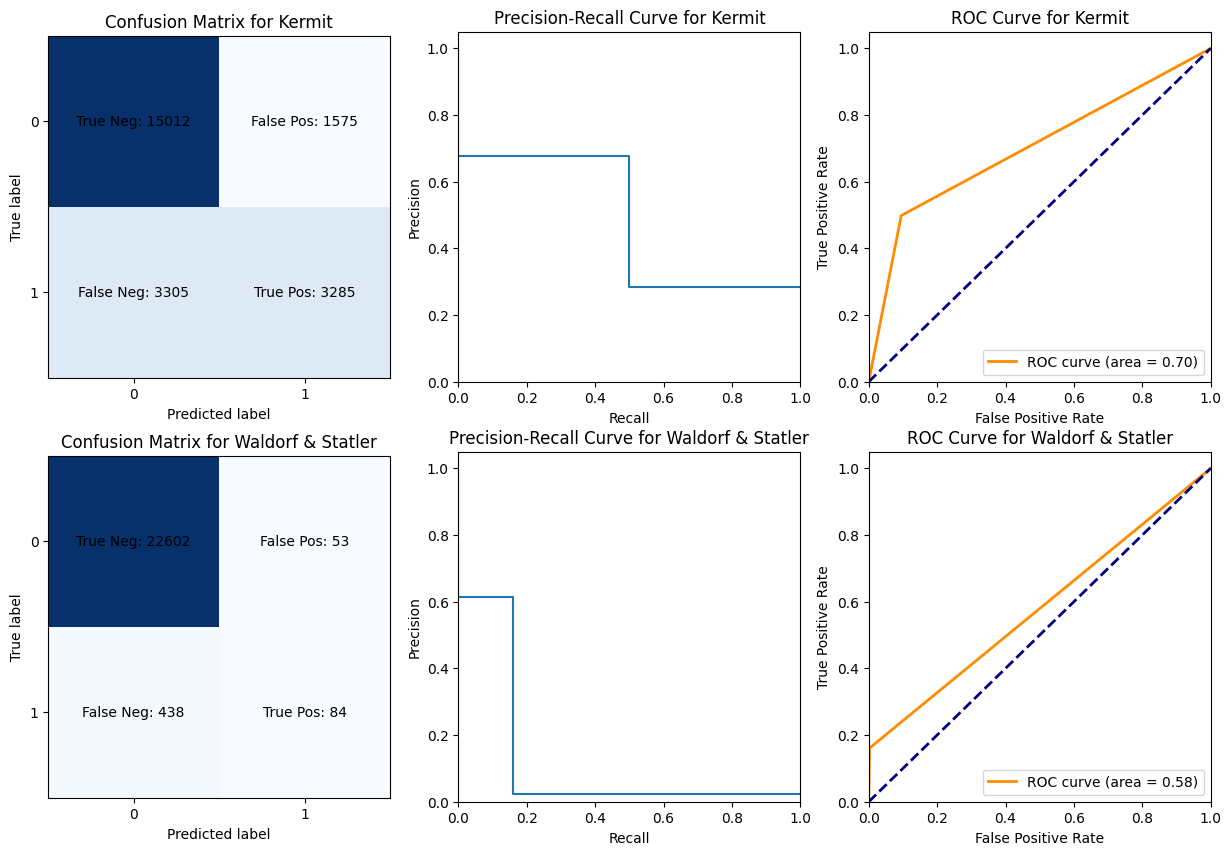

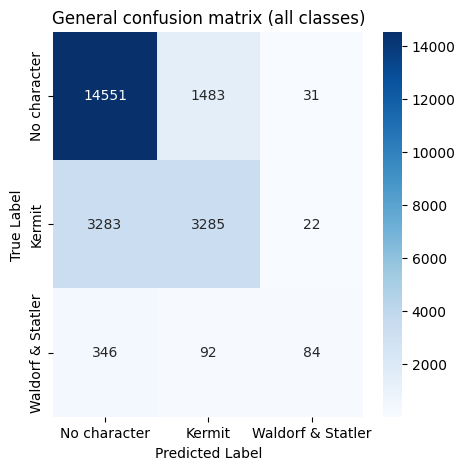

In [21]:
# *** Metrics ***
print(
    f"***General model metrics***\n\tAccuracy: {accuracy_general}\n\tPrecision: {precision_general}\n\tRecall: {recall_general}\n\tF1: {f1_general}"
)
print(
    f"***Kermit***\n\tAccuracy: {accuracy_kermit}\n\tPrecision: {precision_kermit}\n\tRecall: {recall_kermit}\n\tF1: {f1_kermit}\n\tMAP: {map_kermit}"
)
print(
    f"***Waldorf & Statler***\n\tAccuracy: {accuracy_wald_stat}\n\tPrecision: {precision_wald_stat}\n\tRecall: {recall_wald_stat}\n\tF1: {f1_wald_stat}\n\tMAP: {map_wald_stat}"
)

# *** Visual evaluation ***
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# Kermit
plot_confusion_matrix(
    y_test_kermit, y_pred_kermit, "Confusion Matrix for Kermit", ax=axs[0, 0]
)
plot_precision_recall_curve(
    y_test_kermit, y_pred_kermit, "Precision-Recall Curve for Kermit", ax=axs[0, 1]
)
plot_roc_curve(y_test_kermit, y_pred_kermit, "ROC Curve for Kermit", ax=axs[0, 2])
# Waldorf & Statler
plot_confusion_matrix(
    y_test_wald_stat,
    y_pred_wald_stat,
    "Confusion Matrix for Waldorf & Statler",
    ax=axs[1, 0],
)
plot_precision_recall_curve(
    y_test_wald_stat,
    y_pred_wald_stat,
    "Precision-Recall Curve for Waldorf & Statler",
    ax=axs[1, 1],
)
plot_roc_curve(
    y_test_wald_stat, y_pred_wald_stat, "ROC Curve for Waldorf & Statler", ax=axs[1, 2]
)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_global_confusion_matrix(
    y_test,
    y_pred,
    "Kermit",
    "Waldorf & Statler",
)


### Result discussion, observations and other things we tried to improve performance

The performance of the model has been evaluated under three angles:

- Kermit classification (_metrics/plots for success at classifying frames where the Kermit flag is true_). **_Reminder_**: as stated previously, for Kermit, there are no "audio-only" annotations, there might be undetected true positives/true negatives in the Kermit classification as the model might predict the absence of Kermit due to him not making sounds in the frame, but he might be present in the video making the label 1.
- Waldorf & Statler classification (_metrics/plots for success at classifying frames where the Waldorf & Statler audio flag is true_).
- Overall classification performance (_metrics/plots for the general multi-class classification task - weighted performance metrics have been employed_).

The best performing model uses the following features (_explanations on why we chose them for characteristics of the characters are given in the feature extraction part of the notebook_):

- Loudness (through RMS energy).
- Zero-crossing rate.
- 19 MFCCs to describe the timbre/the short-term power spectrum of the sound.

All these features are fed, as a vector of values, into a k-nearest-neighbors classifier. All parameters are normalized, to make sure they are all of equal importance in the distance metric that the classifier uses by constraining them to the same order of magnitude. The number of neighbors considered, as well as the distance metric, are selected based on 5-fold cross-validation on the training dataset.  
This way, the best performing model, with the features described above, achieves the following performance metrics (we report them for both the random and non-random split of the dataset described in the data splitting part of the notebook):

**Performance with the random split:**

<table>
<thead>
  <tr>
    <th><b>Experiment</b></th>
    <th><b>F1 (Kermit)</b></th>
    <th><b>Accuracy</b></th>
    <th><b>Precision</b></th>
    <th><b>Recall</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>Kermit detection</b></td>
    <td>0.5738</td>
    <td>0.7894</td>
    <td>0.6759</td>
    <td>0.4985</td>
  </tr>
  <tr>
    <td><b>Waldorf & Statler detection</b></td>
    <td>0.2549</td>
    <td>0.9788</td>
    <td>0.6131</td>
    <td>0.1609</td>

  </tr>
  <tr>
    <td><b>Overall multi-class classification</b></td>
    <td>0.7579</td>
    <td>0.7732</td>
    <td>0.7608</td>
    <td>0.7732</td>
  </tr>
</tbody>
</table>
<img src="https://lh3.googleusercontent.com/drive-viewer/AK7aPaAdmln2FhSymnF50nTjwm_lysKXoaCsJpwmALO9oIT4rGDm_A1ExKH59Ik8WA5Vi5H2iU8PWQ0Pvf4ZyR5zi7ftPpVktA=s1600" style="max-width:75%; display: block; margin: 0 auto">

**Performance with the non-random split:**

<table>
<thead>
  <tr>
    <th><b>Classification task</b></th>
    <th><b>F1</b></th>
    <th><b>Accuracy</b></th>
    <th><b>Precision</b></th>
    <th><b>Recall</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>Kermit detection</b></td>
    <td>0.31</td>
    <td>0.5457</td>
    <td>0.4746</td>
    <td>0.2301</td>
  </tr>
  <tr>
    <td><b>Waldorf & Statler detection</b></td>
    <td>0.0837</td>
    <td>0.9839</td>
    <td>0.1735</td>
    <td>0.0552</td>
  </tr>
  <tr>
    <td><b>Overall multi-class classification</b></td>
    <td>0.4928</td>
    <td>0.5345</td>
    <td>0.5132</td>
    <td>0.5345</td>
  </tr>
</tbody>
</table>
<img src="https://lh3.googleusercontent.com/drive-viewer/AK7aPaBJx_D-G6cUEtJyvAFejsuU7WCSCMzbqWJmQdtxbHP1pAFfwLAsovpjY6Or2hYLXP1g2j2rTDi5oPwGYr8JbnxYHIfinQ=s1600" style="max-width:75%; display: block; margin: 0 auto">

A clear difference can be observed between the performance metrics/graphs for the random and non-random split of the dataset. We suspected this might be due to multiple potential reasons. Neighboring frames are highly correlated, and we would have such neighboring frames in both the train and test sets if we used a random split, leading to "artificially" higher performance. Moreover, the non-random split cuts off the last part of the last video. That part contains extremely little samples for Waldorf & Statler, and might also present very specific configurations of the characters that are not present in the rest of the dataset as it could be a quite different scene, leading to a worse performance on evaluation. In the rest of this commentary, we will compare the performance metrics for the random split, but all experiments have been executed with both approaches implemented in this notebooks, and we include the measurements for both splits in our `results` folder.
The general performance we have achieved is not as good as we would wish, but it still can bring valuable information to the hybrid classifier that also uses visual information - detecting solely on audio is not as easy. We observe that the model works significantly better for detecting Kermit, which we expected: his audio patterns are more specific and easier to detect than Waldorf & Statler's, and most importantly, he's way more present in the dataset, allowing the model to learn more about his audio patterns (Kermit is present in 6590 frames of the test set, against 522 for Waldorf & Statler out of 23177 total frames). For Kermit detection, recall is lower than other performance metrics, and as the confusion matrix confirms, false negatives are the biggest problem of the model. And this is even though we optimized the cross validation based on recall, as we saw that this is the main problem. This performance is reflected in the ROC and precision-recall curves that, while they are not totally bad (area of 0 for the precision-recall and a diagonal line for the ROC curve would be the worst possible), they are not as good as we would wish.  
For Waldorf & Statler, the model performs significantly worse, but still somewhat better than random guessing (as can be seen on the ROC curve that is not exactly diagonal). Both curves are a lot closer to the worst possible than for Kermit, and this is reflected in the performance metrics and confusion matrix as well. The confusion matrix shows that the model has a tendency towards false negatives as well, which we mostly blame on the very low presence of the characters in the dataset (only 522 / 23177 frames for the test set). The performance is poor, and we tried multiple approaches to fix this as it will be described in the next section, but this is the best performance we got. Finally, the general performance metrics for the multi-class classification task are quite good, but this is only due to the high-presence of Kermit in the dataset, and that most frames of the dataset are of class "no character". As the model has a tendency towards false negatives, this explains the inflated average performance metrics, and underlines the importance on the per-character evaluation we did before.

**Even though the above performance is the best we achieved, multiple approaches have been tried to improve the performance of the model.**

- As we use a k-NN classifier, the many MFCC features might override the importance of ZCR/loudness. We tried to use statistical moments of the MFCCs (mean, standard deviation, skewness, kurtosis...) instead of the full representation to limit this, but this led to a (slightly) worse performance. We suspect that this is due to the fact that the full representation of the MFCCs is more expressive and allows the model to learn more about the audio patterns of the characters, and we have therefore kept the full representation.
- We have experimented with different numbers of MFCC features as well. We have seen a significant increase in performance when scaling the number between 13 and 19, and after 19, the performance decreased. We have therefore kept 19 MFCCs.
- In general, for the k-NN classifier, we have observed a precision/recall tradeoff based on the chosen value for `k`: lower values led to less false negatives while higher values led to higher precision.
- We also experimented with multiple other audio feature-engineering methods specifically aimed at the specific patterns of Waldorf and Statler (_low, cranky voices with a very specific overtone structure, leading us to focus on spectral and timber features_) as those were our major problem.

  - We tried extracting spectral contrast to measure the difference in amplitude between peaks and valleys in the spectrum, capturing some aspects of timbre.
  - We also used spectral roll-off, providing insights into the shape of the spectral energy distribution, affecting the timbre.
  - Spectral centroids have been tried to describe the brightness of the sound.
  - Pitch has been extracted, and its statistical moments were used as features as well.
  - We also gave chroma features a try in an effort to achieve better performance by capturing the energy distribution across different pitch classes to provide a view of the harmonic content that contributes to timbre.

  However, none of these approaches led to an improvement in performance (whether by itself, or in combinations of features). For multiple features, we also observed in their statistical distribution that they were almost always of value almost 1 (once normalized), bringing little to no information to the classifier. The feature extraction is included in this notebook, even for the features we did not keep.

**Performance summary of some of the other attempted experiments - measured on the random split:**
**Performance with the random split:**

<table>
<thead>
  <tr>
    <th><b>Experiment</b></th>
    <th><b>F1 (Kermit)</b></th>
    <th><b>Precision (Kermit)</b></th>
    <th><b>Recall (Kermit)</b></th>
    <th><b>F1 (Waldorf & Statler)</b></th>
    <th><b>Precision (Waldorf & Statler)</b></th>
    <th><b>Recall (Waldorf & Statler)</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>RMS+ZCR+13 MFCCs</b></td> <!-- Experiment -->
    <td>0.5387</td> <!-- F1 Kermit -->
    <td>0.6737</td> <!-- Prec Kermit -->
    <td>0.4487</td> <!-- Rec Kermit -->
    <td>0.1417</td> <!-- F1 W&S -->
    <td>0.5915</td> <!-- Prec W&S -->
    <td>0.0805</td> <!-- Rec W&S -->
  </tr>
  <tr>
    <td><b>RMS+ZCR+7 Spectral contrasts</b></td> <!-- Experiment -->
    <td>0.1816</td> <!-- F1 Kermit -->
    <td>0.4711</td> <!-- Prec Kermit -->
    <td>0.1124</td> <!-- Rec Kermit -->
    <td>0</td> <!-- F1 W&S -->
    <td>0</td> <!-- Prec W&S -->
    <td>0</td> <!-- Rec W&S -->
  </tr>
  <tr>
    <td><b>RMS+ZCR+Spectral centroid+Spectral roll-off</b></td> <!-- Experiment -->
    <td>0.1760</td> <!-- F1 Kermit -->
    <td>0.4573</td> <!-- Prec Kermit -->
    <td>0.1090</td> <!-- Rec Kermit -->
    <td>0</td> <!-- F1 W&S -->
    <td>0</td> <!-- Prec W&S -->
    <td>0</td> <!-- Rec W&S -->
  </tr>
  <tr>
    <td><b>RMS+ZCR+Chroma features</b></td> <!-- Experiment -->
    <td>0.1396</td> <!-- F1 Kermit -->
    <td>0.4530</td> <!-- Prec Kermit -->
    <td>0.0825</td> <!-- Rec Kermit -->
    <td>0</td> <!-- F1 W&S -->
    <td>0</td> <!-- Prec W&S -->
    <td>0</td> <!-- Rec W&S -->
  </tr>
  <tr>
    <td><b>RMS+ZCR+Pitch</b></td> <!-- Experiment -->
    <td>0.3253</td> <!-- F1 Kermit -->
    <td>0.4421</td> <!-- Prec Kermit -->
    <td>0.2574</td> <!-- Rec Kermit -->
    <td>0</td> <!-- F1 W&S -->
    <td>0</td> <!-- Prec W&S -->
    <td>0</td> <!-- Rec W&S -->
  </tr>
</tbody>
</table>
